# Import package

In [1]:
import numpy as np
from numpy import nan
from numpy import isnan
from numpy import split
from numpy import array
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import *
plt.rcParams['font.sans-serif'] = ['SimHei']

import math
from math import sqrt

import re
import tqdm
import random
import os
import itertools
import argparse
import joblib
import xlrd
from collections import defaultdict
import copy

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import datetime
import calendar
import time
from datetime import date,datetime

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import seaborn as sns
import stats as sts#df2

from scipy import stats
from scipy.special import softmax

from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import torch
import torch.nn as nn


Bad key "nbagg.transparent" on line 426 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution
In D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.

# Load data

In [2]:
abc=30#表示30min为一段
gdf0=pd.read_csv(r'E:\博士科研资料\博士开题及其素材\加油站数据\export11.csv',encoding='gb18030')
gdf0['Time1'] = pd.to_datetime(gdf0['Time'],errors='coerce') 
gdf0['Hour'] = gdf0['Time1'].dt.hour.fillna(0).astype("int")    #转化提取小时
gdf0['Minute'] = gdf0['Time1'].dt.minute.fillna(0).astype("int") #转化提取分钟
gdf0['Hour']=gdf0['Hour'].astype(str)
gdf0['Date'] = pd.to_datetime(gdf0['Date'])
gdf0['T'] = gdf0['Hour'].apply(lambda x : int(x))+gdf0['Minute'].apply (lambda x :round(x/60,2))
gdf0['volume'] = gdf0['volume']
gdf0['MinuteLabel']=gdf0['Hour'].apply(lambda x : math.floor((int(x)*60)/abc))+gdf0['Minute'].apply (lambda x :math.floor(x/abc))#表示该时刻点属于哪个区间,因为有0，所以向下取整数
day_name00=gdf0.groupby(["NAME"])         #
for name,group in day_name00:#group是星期数一样的类目
    if name=='92H':
        df0=group
df0=df0[df0['Date'] >= "2020-06-01"] 
df0= df0[~( df0['Date'].isin(["2020-06-11","2020-08-11", "2020-08-25", "2020-09-11"]) )]###删除这些行，因为很多0

# Data preprogressing

In [3]:
DFStockOut=df0.iloc[:,[6,7,11,3,10,12]]
c=3
a=DFStockOut.shape[1]
ReStartStock=13790#10000#该变量表示补货到达后的初始库存
DFStockOut['OurLeaveStock']=DFStockOut['Date'].apply(lambda x : ReStartStock)#6
DFStockOut['OurBuHuoStart']=DFStockOut['Date'].apply(lambda x : 0)#补货触发时刻7
b=a+1
DFStockOut['Date']=pd.to_datetime(DFStockOut['Date'])

StockOutTime=[]
DHCS1=0#表示订货次数
DFStockOut['AllMinutes']=DFStockOut['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(DFStockOut.shape[0]):
    if DFStockOut.iloc[i,-1]=="00:00:00":
        DFStockOut.iloc[i,-1]="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59
DFStockOut['timestamp']=DFStockOut['Date'].astype('str')+ ' ' + DFStockOut['AllMinutes'].astype('str')
DFStockOut['timestamp'] = pd.to_datetime(DFStockOut['timestamp'])#pd.to_datetime它无法转换
print(DFStockOut.shape)#(321121, 9)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(207441, 10)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
df2 = df0.groupby(["Date","MinuteLabel"])['volume'].sum().reset_index(name ='UnitSales')#只留下小时销量数据
df2['Date'] = pd.to_datetime(df2['Date']) 
df2['Month_id']=df2['Date'].dt.month
df2['weekday'] = df2['Date'].apply(lambda time: time.dayofweek)
df2['MinuteLabel']=df2['MinuteLabel'].astype(str)
df2['weekday_hour'] = df2.weekday.astype(str) +' '+ df2.MinuteLabel.astype(str)
df2['m_weekday'] = df2.weekday_hour.replace(df2[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
init1 = df2.m_weekday[:].apply(np.log).values#均值取对数df5['UnitSales'
df2['PreproccessUnitSales'] =df2.UnitSales[:].apply(np.log).values - init1#数取对数-均值的对数
dfghu=df2.sort_values(by=['UnitSales'],ascending=[True]) 
df2['UnitSales']=df2['UnitSales'].apply(lambda x: (x-dfghu.iloc[0,2])/(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2]))

In [5]:
df2['MinuteLabel']=df2['MinuteLabel'].astype(int)#
idx=list(range(0,int(24*60/abc)))                                                         
i=0
colorSet=['cyan','g','palegreen','c','lime','tomato','r']
DayName=['Mony','Tues','Wednes', 'Thurs', 'Fri', 'Satur', 'Sun']
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_name=df2.groupby(["weekday"])         #
for name,group in day_name:#group是星期数一样的类目
    group1=group.groupby(["Date"])
    j=0
    for name,group2 in group1:#group2是星期数、日期数一样的类目，即一天  
         group2=group2.sort_values(by=['MinuteLabel'],ascending=True,na_position='first')  # 按时间排序                  
         group2 = group2.set_index('MinuteLabel')#group2设置索引为Hour         
         group2 = group2.reindex(idx, fill_value=0)
         group2['MinuteLabel'] = group2.index          
         group2['Date']=name
         group2['weekday'] = group2['Date'].apply(lambda time: time.dayofweek)
         group2['day_name']=group2['weekday'].apply (lambda x : days[x])
         if i==0 and j==0:
            df3=group2
         else:      
            df3=pd.concat([df3,group2], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
         j=j+1
    i=i+1

df3=df3.sort_values(by=['Date','MinuteLabel'],ascending=[True,True]) #df3是没有的，用0不足的dataframe
df3['HourLabel']=df3['MinuteLabel'].apply(lambda x: math.floor(x*abc/60))

In [6]:
df5=df3.iloc[:,:]
df3['HourLabel']=df3['HourLabel'].astype(int)
df5['weekday'] = df5.Date.dt.weekday
df5['weekday_hour'] = df5.weekday.astype(str) +' '+ df5.HourLabel.astype(str)
df5['m_weekday'] = df5.weekday_hour.replace(df5[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
df5.to_csv('hour_Demand_consumption.csv')
df = pd.DataFrame(columns=['timestamp', 'value'])###初始化
df5['AllMinutes']=df5['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(df5.shape[0]):
    if df5.loc[i,'AllMinutes']=="00:00:00": 
        df5.loc[i,'AllMinutes']="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59
#将秒转换为时分秒的形式
df['timestamp']=df5['Date'].astype('str')+ ' ' + df5['AllMinutes'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])#为什么成了选取偶数
#df['value']=df5['UnitSales']+100#将小时销量转换为value值，且为了0不可用，所有的值增加100.
df['value']=df5['UnitSales']
df=df.sort_values(by=['timestamp'],ascending=[True]) 
df['Date']=df['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))#提取时间戳中的日期
df['MinuteLabel']=df5['MinuteLabel']
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df5['HourLabel']
df['Mi'] = df5['MinuteLabel']#
df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.Mi.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:].groupby('weekday_hour')['value'].mean().to_dict())
df=df.sort_values(by=['timestamp','Mi'],ascending=[True,True]) #df3是没有的，用0不足的dataframe

# Multi-step-ahead forecasting model

## Define functions

In [7]:
###00数据裂变划分,用于自定义函数DataPreprogress(df)
def to_supervised2(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < (len(data)+1):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1    # 依次推进时间
    return array(X), array(y)
###01前期数据准备
def DataPreprogress(df):
    init1 = df.m_weekday[:].apply(lambda x: 0).values#均值取对数
    label1 = df.value[:].values - init1#没必要取对数吧
    Date1=df.timestamp[:]#获得对应时间戳
    label1=np.array(label1).reshape(len(label1),1)#1维变2维
    init1=np.array(init1).reshape(len(init1),1)#1维变2维
    Date1=np.array(Date1).reshape(len(Date1),1)
    Xx, Yy = to_supervised2(label1, n_input, n_out)#准备数据#00
    Date1Xx, Date1Yy = to_supervised2(Date1, n_input, n_out)#准备数据#00
    initXx, initYy = to_supervised2(init1, n_input, n_out)#准备数据#00
    return init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx,initYy
###02将数据分为测试组和训练组
def split_dataset2(x,y):# split a univariate dataset into train/test sets
    train_x, test_x = x[:SplitNum], x[SplitNum:]
    train_y, test_y = y[:SplitNum], y[SplitNum:]
    return train_x, test_x,train_y, test_y
def to_supervised3(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < len(data):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        if (out_end+1) % (int(24*60/abc))==0: #如果能被整除int(nums[0]) % int(nums[1]) == 0:
            in_start += n_input+ n_out
        else:
          in_start += 1    # 依次推进时间
    return array(X), array(y)

In [8]:
###10 构建模型model_list  
def Quantile_fit_lstm(train_x, train_y,q):
    model_list = []
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    def q_loss(q,y,f):### 定义分位数损失函数
        e = (y-f)#真实值-预测值
        return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
    losses = [lambda y,f: q_loss(q,y,f)]#3个分位数的损失函数       
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model
    model.add(Conv1D(filters=245,#建立16个滤镜
                     kernel_size=3,#每一个滤镜的大小
                     padding='same',#产生的卷积图形不变
                     activation='relu',
                   ))
    # 建立一维池化层1
    model.add(MaxPooling1D(pool_size=2))
    #建立平坦层
    model.add(Flatten())
    # 输出层
    ###200表示隐藏状态维度
    model.add(Dense(n_outputs))
    print('00losses',losses)
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.002673537340293113), loss=losses)  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=80, batch_size=8, verbose=0, shuffle=False)
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    model_list.append(model)#保存model
    return model_list
###11 构建模型model_list  
def Traditional_fit_lstm(train_x, train_y):
    model_list = []
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model
    model.add(Conv1D(filters=490,#建立16个滤镜
                     kernel_size=3,#每一个滤镜的大小
                     padding='same',#产生的卷积图形不变
                     activation='relu',
                   ))
    # 建立一维池化层1
    model.add(MaxPooling1D(pool_size=2))
    #建立平坦层
    model.add(Flatten())
    # 输出层
    ###200表示隐藏状态维度
    model.add(Dense(n_outputs))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0012798558717290274), loss='mse')  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=80, batch_size=32, verbose=0, shuffle=False)
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    model_list.append(model)#保存model
    return model_list
###13 模型构建（3类模型重复5次）
def QuanModelListBuild(train_x, train_y,q):
    QuanModelList=[]#将3类modelList放一起
    model1_list = Traditional_fit_lstm(train_x, train_y)###这是点预测
    QuanModelList.append(model1_list)
    for i in range(len(q)):
        model1_list = Quantile_fit_lstm(train_x, train_y,q[i])###这是分位数预测
        QuanModelList.append(model1_list)
    return QuanModelList

In [9]:
###02 基于01模型进行预测
def forecast2(model, test_x,inittest_y,q):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    for i in tqdm.tqdm(range(0,1)):#利用dropout将预测迭代100次，将其存储起来，选择q的百分位预测值
        ##每次迭代得到的结果一样，所以可以不用那么多次
        predd = model.predict(input_x, verbose=0)    
        predd = predd[0]# we only want the vector forecast
        predd = predd.reshape((len(predd), 1))
        pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m = (pred_00[0]+ inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    return pred_00_m
def forecast3(model, test_x,inittest_y):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    for i in tqdm.tqdm(range(0,1)):#利用dropout将预测迭代100次，将其存储起来，选择q的百分位预测值
        predd = model.predict(input_x, verbose=0)    
        predd = predd[0]# we only want the vector forecast
        predd = predd.reshape((len(predd), 1))
        pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m =(pred_00[0]+inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    return pred_00_m

###03,测试部分,基于预测模型得到预测值
def PredictValueTest(QuanModelList,test_x,inittest_y,q):
    ii=0#表示model1_list
    predictionspredList=[]#得到多个分位数预测模型、不同重复次数下的预测值集合（predictionspredList）
    for model_list in QuanModelList:
        predictionspredList.append([])#第一层是不同分位数下的模型，分别为10%、50%、90%
        for i in range(len(model_list)):
            model = model_list[i]
            predictionspredList[-1].append([])#第二层是相同分位数模型下不同重复次数下的模型
            for ij in range(len(test_x)):
                if ii==0:
                    pred = forecast3(model,test_x[ij,:], inittest_y[ij,:])#得到预测值
                else:
                    pred = forecast2(model,test_x[ij,:], inittest_y[ij,:],q[ii-1])#得到预测值
                predictionspredList[-1][-1].append(pred)
            predictionspredList[-1][-1] = array(predictionspredList[-1][-1])#list转换为数组
        ii=ii+1#表示model_list进入下一个，主要是为了q[i]取值
    return  predictionspredList

In [10]:
def q_loss(q,y,f):### 定义分位数损失函数
    e = (y-f)#真实值-预测值
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
#03评估预测误差
def evaluate_forecasts1(actual, predicted):#返回预测值的总RMSE以及每天RMSE的列表
    scores = list() 
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])#计算MSE
        rmse = sqrt(mse)#计算RMSE
        scores.append(rmse)#计算每个预测值的RMSE,存放在列表#这个现在来看没有多大意义，因为不是同一个时刻,表示向前1步、2步、几步的预测效果
    s = 0
    sMAE = 0
    sMAPE = 0
    RMSE1=list()
    for row in range(actual.shape[0]):
        ss=0
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
            ss+= (actual[row, col] - predicted[row, col]) ** 2
            sMAE+= np.abs(actual[row, col] - predicted[row, col])
            sMAPE+= np.abs((actual[row, col] - predicted[row, col])/actual[row, col])
        RMSE1.append(sqrt(ss/actual.shape[1]))##每一组的RMSE
    AllNum=actual.shape[0] * actual.shape[1]
    AllRMSE = sqrt(s / AllNum)#计算所有值的RMSE
    AllMSE = s / AllNum#计算所有值的RMSE
    AllMAE =sMAE/AllNum
    AllMAPE =sMAPE/AllNum  
    name='[Num]/RMSE/MSE/MAE/MAPE'
    SingPredictscores = list() 
    SingPredictscores.append(AllRMSE)
    SingPredictscores.append(AllMSE)
    SingPredictscores.append(AllMAE)
    SingPredictscores.append(AllMAPE)
    SingPredictscores = ', '.join(['%.1f' % s for s in SingPredictscores])
    return AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum
###06
def summarize_scores(name, score, scores):#总结分数
    s_scores = ', '.join(['%.1f' % s for s in scores])

###04 测试部分，预测结果的传统评价
def  ValueTest(test_y,inittest_y,predictionspredList):
    ###得到测试y值的原始值
    test_y1=test_y.copy()## 对原始的array1的复制
    for i in range(test_y.shape[0]):
        test_y1[i, :]=(test_y[i, :] + inittest_y[i,:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]#不用求exp啦
    iii=0
    PredictScresSet=list()
    for preddd in predictionspredList:
        for predictionspredI in preddd:
            PredictScresSet.append([])
            AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum=evaluate_forecasts1(test_y1[:, :], predictionspredI)
            PredictScresSet[-1].append(AllRMSE)
            PredictScresSet[-1].append(AllMSE)
            PredictScresSet[-1].append(AllMAE)
            PredictScresSet[-1].append(AllMAPE)
            PredictScresSet[-1].append(AllNum)
            days = range(n_out) 
        iii=iii+1
    return PredictScresSet

## Train the forecasting models

In [11]:
from tensorflow.keras import optimizers

len(train_x), len(test_x),len(train_y), len(test_y) 6956 3117 6956 3117
10073 10073
00losses [<function Quantile_fit_lstm.<locals>.<lambda> at 0x000001FFC88D70D0>]


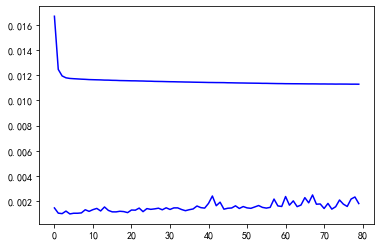

In [12]:
###定义参数取值
n_input =4
n_out = 4
q=[0.999]
inv_yhat_list = []
inv_y_list = []
global SplitNum
SplitNum=int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)-n_input-48*2##天数的百分之0.7,再乘以48
###00前期数据准备
init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx, initYy=DataPreprogress(df)
##数据拆分
train_x, test_x,train_y, test_y = split_dataset2(Xx, Yy)#01
print('len(train_x), len(test_x),len(train_y), len(test_y)',len(train_x), len(test_x),len(train_y), len(test_y))
print(len(Xx), len(Yy))
inittrain_x, inittest_x,inittrain_y, inittest_y = split_dataset2(initXx, initYy)#01
Datetrain_x, Datetest_x,Datetrain_y, Datetest_y = split_dataset2(Date1Xx, Date1Yy)#01
###01 模型构建（3类模型重复5次）
LSTMQuanModelList=QuanModelListBuild(train_x, train_y,q)

In [13]:
print('int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)',int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc))

int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc) 7056


## Get the forecasted values based on the testing data

In [14]:
###03,测试部分,基于预测模型得到预测值
predictionspredList=PredictValueTest(LSTMQuanModelList,test_x,inittest_y,q)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.73it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.65it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.31it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.68it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


In [15]:
###04 测试部分，预测结果的传统评价
LSTMPredictScresSet0=ValueTest(test_y,inittest_y,predictionspredList)

In [16]:
ForecastResult = pd.DataFrame(columns = ['Name','RMSE','MSE','MAE']) 
NameList=['点预测']
for i in range(len(q)):
    str0='第'
    str1=str(q[i])
    str2='分位数'
    strall=str0+str1+str2
    NameList.append(strall)
print('NameList',NameList)    
for i in range(1+len(q)):
    ForecastResult0 = pd.DataFrame(columns = ['Name','RMSE','MSE','MAE'])
    ForecastResult0.loc[0,'Name']=NameList[i]
    ForecastResult0.loc[0,'RMSE']=round(LSTMPredictScresSet0[i][0],2)
    ForecastResult0.loc[0,'MSE']=round(LSTMPredictScresSet0[i][1],2)
    ForecastResult0.loc[0,'MAE']=round(LSTMPredictScresSet0[i][2],2)
    ForecastResult=pd.concat([ForecastResult,ForecastResult0], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   



NameList ['点预测', '第0.999分位数']


In [17]:
display(ForecastResult.head(50))

,Name,RMSE,MSE,MAE
0,点预测,272.59,74307.4,205.22
1,第0.999分位数,2699.07,7.285e+06,2481.05


#  Determine total cost and service level and get csv

## Define function

In [18]:
def SingleQHSJPD(ComparResultdf,NameList,djq):###djq表示在模型中属于第几个
    ##################初始化预测值#################
    predictionspredList11=[]
    for i in range(len(predictionspredList)):
        predictionspredList11.append([])
        for j in range(len(predictionspredList[i])):
            predictionspredList11[-1].append([])
            for k in range(len(predictionspredList[i][j])):
                predictionspredList11[-1][-1].append([])
                for ij in range(len(predictionspredList[i][j][k])):
                    predictionspredList11[-1][-1][-1].append(0)
                    predictionspredList11[i][j][k][ij]=predictionspredList[i][j][k][ij]#前面没减，就不用了"""
    df_test1  = df[(df.timestamp>=pd.to_datetime(Datetest_x[0][0][0]))]#df是按照单位时间（abc）聚合后的所有数据
    df_test1.index = pd.DatetimeIndex(df_test1['timestamp'])
    df_testXX=df_test1.iloc[:,0:3]#
    df_testXX['value']=df_testXX['value'].apply(lambda x: x*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2])#减去加的那100
    df_testXX['timestamp'] = pd.to_datetime(df_testXX['timestamp'])#为什么成了选取偶数
    df_testXX['Hour'] = df_testXX['timestamp'].dt.hour.astype("int") #转化提取分钟
    df_testXX['Minute'] = df_testXX['timestamp'].dt.minute.astype("int") #转化提取分钟
    c1=1#c1表示消耗量所在列
    a1=df_testXX.shape[1]
    df_testXX['OurLeaveStock']=df_testXX['timestamp'].apply(lambda x : ReStartStock)#5
    b1=a1+1
    df_testXX['OurBuHuoStart']=df_testXX['timestamp'].apply(lambda x : 0)#补货触发时刻7
        ###参数更新
    def updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS):#更新参数的自定义函数
        NoOS+=1#
        ActualTimeOS=0
        PredictTimeOS=df_testXX.iloc[mm+3,0]#预测的缺货时刻
        ActualDate=0
        DHCS1=DHCS1+1
        #tt=df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60+IntervalT##tt表示补货到达时刻
        if df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60==23+(59/60):       
            tt=0+IntervalT##tt表示补货到达时刻
            ###11##print('00中tt',tt)
        else:
            tt= df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60+IntervalT##tt表示补货到达时刻
            ###11##print('11中tt',tt)
        dd=1
        BHVolume=ReStartStock-df_testXX.iloc[mm,a1]#补货量10000-当前库存水平
        NewTC0=NewTC0+Dcc0#订购一次1500元
        return DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS, ActualDate
    ###变动的参数
    hh=1100/(365*24*1378)# 1吨≈1378L，持有成本1100元/吨/年
    tt=0#表示补货时间
    DHCS1=0#表示订货次数
    NoOfStockout0=0
    dd=0
    ###计算库存成本相关的参数
    tt1=df_testXX.iloc[0,0]#表示上一次补货到达时刻
    ReStartStock00=ReStartStock##初始化周期初，库存水平
    NewTC0=0
    global Dcc0
    Dcc0=150#一次订购成本
    ##生成缺货情况表
    dfTimeOutOfStock= pd.DataFrame(columns=('No', 'PredictTime','ActualDate', 'ActualTime','InventoryLevel'))
    NoOS=-1#
    InventoryLevel=0#补货到达时，库存水平
    PredictTimeOS=0#预测的缺货时刻
    ActualDate=0
    ActualTimeOS=0#实际缺货时刻
    ####第一组,重新计算剩余库存以初始化
    for i in range(len(Datetest_x[0])):
        if i==0:
            df_testXX.iloc[i,a1]=df_testXX.iloc[i,a1]-df_testXX.iloc[i,c1]
        else:             
            df_testXX.iloc[i,a1]=df_testXX.iloc[i-1,a1]-df_testXX.iloc[i,c1]#表示剩余库存水平#
    ###11##print('df_testXX.iloc[mm,a1]',df_testXX.iloc[0,a1])
    mm=i+1#初始化mm.注，预测的是Datetest_y，其对应的第一组值为 [['2017-03-11T01:30:00.000000000' '2017-03-11T02:00:00.000000000' '2017-03-11T02:30:00.000000000']
    ###我的预测方法下预测的缺货时间
    ###11##print('我的预测方法下预测的缺货时间')
    for k in range(1,len(predictionspredList[-1][0]),1): ##除了第一组，后面只取预测的第一个值
    ##00未来需求的求和，对应step3                
        SumDemand=0##SumDemand表示未来1个时段内的总需求
        for h in range(len(predictionspredList11[djq][0][k])):
            SumDemand=SumDemand+predictionspredList11[djq][0][k][h]       
        SumDemandPus1=SumDemand#SumDemandPus1表示未来2个时段内的总需求
        if k==len(predictionspredList[-1][0])-1:
            SumDemandPus1= SumDemandPus1+0#如果是最后一个则+0
        else:
            SumDemandPus1= SumDemandPus1+predictionspredList11[djq][0][k+1][-1]#只需向前多滚动一个单位时间即可
        if SumDemand>=df_testXX.iloc[mm,a1] and tt==0:#tt=0表示首次补货
             ###11##print('\033[0;36m前期没做好，来不及实施应急补货，\033[0m')
             DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS)
        else:                    
                if SumDemandPus1>df_testXX.iloc[mm,a1] and tt==0:#（2）去掉了=
                     ###11##print('\033[0;32m不能满足SumDemandPus1导致的缺货时间00为\033[0m',df_testXX.iloc[mm,0])                 
                     DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS)
                else:                
                    TestDFStockOut2 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]#mm确实应该加1###TestDFStockOut2表示未来第一个时段内的所有真实需求
                    ###TestDFStockOut2表示未来第一个时段内的所有真实需求
                    TestDFStockOut2 = TestDFStockOut2.sort_values(by=['timestamp'],ascending=[True])#排序
                    singleSumDemand=0
                    for ii in range(TestDFStockOut2.shape[0]):
                        singleSumDemand=singleSumDemand+TestDFStockOut2.iloc[ii,3]
                        if singleSumDemand>=predictionspredList11[djq][0][k][0]:#未未来第一个时段内的预测需求
                            #if df_testXX.iloc[mm,a1]-singleSumDemand <= (SumDemandPus1-singleSumDemand )and tt==0: 
                            if df_testXX.iloc[mm,a1]-singleSumDemand <= (SumDemand-singleSumDemand )and tt==0:
                                 ###11##print('事件驱动下的缺货时间11为',TestDFStockOut2.iloc[ii,0], TestDFStockOut2.iloc[ii,1])
                                 NoOS+=1
                                 PredictTimeOS=TestDFStockOut2.iloc[ii+3,-1]
                                 DHCS1=DHCS1+1
                                 NewTC0=NewTC0+Dcc0
                                 tt=TestDFStockOut2.iloc[ii,2]+IntervalT#补货到达时间
                                 ActualTimeOS=0
                                 ActualDate=0
                                 dd=1
                                 BHVolume=ReStartStock-(df_testXX.iloc[mm,a1]-singleSumDemand)#补货量
                                 continue#出现了缺货时间后，这部分就可以不用继续拉                       
    ##02获得实际缺货的时间（主要是防止真实需求的波动性，可能会导致缺货时间发生在补货到达前）
        if tt!=0 and dd==1:##dd==0 or 1用来调节 缺货时间只有一个，库存水平后面不能继续为负
            TestDFStockOut3 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]###TestDFStockOut2表示未来第一个时段内的所有真实需求
            TestDFStockOut3 = TestDFStockOut3.sort_values(by=['timestamp'],ascending=[True])#排序
            singleSumDemand1=0
            for ii in range(TestDFStockOut3.shape[0]):
                singleSumDemand1=singleSumDemand1+TestDFStockOut3.iloc[ii,3]
                if df_testXX.iloc[mm,a1]-singleSumDemand1 <= 0 and dd==1:
                    NoOfStockout0=NoOfStockout0+1#该参数表示实际缺货次数
                    ###11##print('\033[0;35m实际缺货时间是\033[0m',TestDFStockOut3.iloc[ii,0], TestDFStockOut3.iloc[ii,1])
                    ActualTimeOS= TestDFStockOut3.iloc[ii,1]
                    ActualDate= TestDFStockOut3.iloc[ii,0]
                    ###11##print('此时的库存水平',df_testXX.iloc[mm,a1]-singleSumDemand1) 
                    dd=2
    ###03 该部分类似于更新，补货到达事件和库存消耗事件  
        mm=mm+1#向前滚动一个时间单位, 应该放到最后
        BJtt = df_testXX.iloc[mm,3]+ df_testXX.iloc[mm,4]/60   #转化为实数版本的小时  
        if tt!=0: ###补货到达 （BJtt为大于tt的最小时间）
            if tt>=24.0:###对于补货到达时间是24.5、25等情况怎么处理
                if BJtt==23+(59/60):
                    tt=tt-24
                    BJtt=0
                    ###11##print('补货到达时刻为',df_testXX.iloc[mm,0], BJtt)##tt才是补货到达时刻
                    ###11##print('tt',tt)##tt才是补货到达时刻
            if tt<=BJtt: ###补货到达 （BJtt为大于tt的最小时间）
                if dd==2:
                     ###11##print('\033[5;35m之前出现了缺货，但货物在该时间戳内到达\033[0m')#说明前面就出现了缺货,即(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]<0)，而库存水平≥0，所以令其为0
                     df_testXX.iloc[mm-1,a1]=0
                     df_testXX.iloc[mm,a1]=ReStartStock
                     InventoryLevel=0
                     TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                     CYC00=hh*TimeOfDiff*((ReStartStock00+(df_testXX.iloc[mm-1,a1]))/2)#持有成本
                else:#补货到达后的库存水平变化
                    df_testXX.iloc[mm,a1]=ReStartStock
                    InventoryLevel=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]
                    TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                    CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本
                ###11##print('No\PredictTim\\ActualDate\ActualTime\InventoryLevel',NoOS, PredictTimeOS,ActualDate,ActualTimeOS,InventoryLevel)
                new=pd.DataFrame({'No':NoOS, 'PredictTime':PredictTimeOS,'ActualDate':ActualDate,'ActualTime':ActualTimeOS,'InventoryLevel':InventoryLevel},index=[1]) 
                dfTimeOutOfStock=dfTimeOutOfStock.append(new,ignore_index=True) 
                ReStartStock00=df_testXX.iloc[mm,a1]#变量ReStartStock00表示新周期的初始库存
                tt1=df_testXX.iloc[mm,0]#代表上一次补货时+
                NewTC0=NewTC0+CYC00
                tt=0   
                dd=0#用以表示    
            else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样 
        else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样 
        if k==len(predictionspredList[-1][0])-1:
            InventoryLevel=max(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1],0)
            TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
            CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本
            NewTC0=NewTC0+CYC00
    df_testXX.to_csv('QRCNN_库存持有量.csv')
    ####################将结果写入dataframe###################################
    ComparResultdf1 = pd.DataFrame(columns=['name','Number of replenishment','Inventory Cost','Delivery Cost','Total Cost','Number of Stock-out'])
    ComparResultdf1.loc[0,'name']=NameList[djq]
    ComparResultdf1.loc[0,'Number of replenishment']=DHCS1
    ComparResultdf1.loc[0,'Inventory Cost']=round(NewTC0,2)
    ComparResultdf1.loc[0,'Delivery Cost']=round(DHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Total Cost']=round(NewTC0+DHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Number of Stock-out']=NoOfStockout0
    ComparResultdf=pd.concat([ComparResultdf,ComparResultdf1], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
    return ComparResultdf

## Calculating Result and get 'QRCNN_库存持有量.csv'

In [21]:
df_test1  = df[(df.timestamp>=pd.to_datetime(Datetest_x[0][0][0]))]#df是按照单位时间（abc）聚合后的所有数据
df_test1.index = pd.DatetimeIndex(df_test1['timestamp'])
TestDFStockOut1  =  DFStockOut[(DFStockOut.timestamp>=pd.to_datetime(Datetest_y[0][0]))]
TestDFStockOut1.index = pd.DatetimeIndex(TestDFStockOut1['timestamp'])
ReStartStock=60000#44128#34475#13790#该变量表示补货到达后的初始库存，1吨92#汽油=1379L
IntervalT=n_input/2

In [22]:
ComparResultdf01 = pd.DataFrame(columns = ['Number of replenishment','Inventory Cost','Delivery Cost','Total Cost','Number of Stock-out']) 
ComparResultdf01=SingleQHSJPD(ComparResultdf01,NameList,1)###点预测没有CQR值

In [23]:
display(ComparResultdf01.tail(20))

,Number of replenishment,Inventory Cost,Delivery Cost,Total Cost,Number of Stock-out,name
0,50,12870.9,15225,28095.9,0,第0.999分位数
